# Oxygen Evals: Bottom Timeseries in Saanich Inlet, Satrait of Georgia Center and East

In [1]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import cmocean.cm as cm
import copy

from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

import datetime as dt
import arrow
import copy
import math
import matplotlib.dates as mdates
import gsw
from mpl_toolkits.basemap import Basemap

In [2]:
mesh = nc.Dataset('/ocean/atall/MOAD/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/ocean/atall/MOAD/grid/bathymetry_202108.nc')

meshb = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/mesh_mask_202310b.nc')
bathyb = nc.Dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/bathymetry_202310b.nc')
grid = xr.open_dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/bathymetry_202310b.nc', mask_and_scale=False)

depthb = meshb.variables['gdept_0'][:]


In [3]:
# ONC observation
# Obs cordonates (Saanich Inlet) : 48.651366°N, -123.486358°W, 93m
# Obs cordonates: SoG Center: 49.039467°N, -123.425033°W, 305m ; SoG Est: 49.042586°N,  -123.316579°W, 166m
df_oxSI = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/Saanich_Inlet/Patricia_Bay/SI_Venus_Inst_Platform/Rinko_Oxygen_20180101_20201231_SI_edit.csv')
df_oxyC = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/SoG/SoG_Venus_Inst_Plattform/O2Sensor_Oxygen_20180101_20201231_SoGC_edit.csv')
df_oxyE = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/SoG/SoG_Venus_Inst_Plattform/O2Sensor_Oxygen_20180101_20201231_SoGE_edit.csv')
df_saSI = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/Saanich_Inlet/Patricia_Bay/SI_Venus_Inst_Platform/CTDA_Salinity_20180101_20201231_SI_edit.csv')
df_salC = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/SoG/SoG_Venus_Inst_Plattform/CTD_Salinity_20180101_20201231_SoGC_edit.csv')
df_salE = pd.read_csv('/ocean/atall/MOAD/Obs/ONC/SoG/SoG_Venus_Inst_Plattform/CTD_Salinity_20180101_20201231_SoGE_edit.csv')


In [4]:
df_oxyE

,"#""Time UTC (yyyy-mm-ddThh:mm:ss.fffZ)""",Oxygen Concentration Corrected (ml/l)
0,2018-01-01T12:00:00.000Z,4.28288003
1,2018-01-02T12:00:00.000Z,4.178024137
2,2018-01-03T12:00:00.000Z,4.113739235
3,2018-01-04T12:00:00.000Z,4.021568367
4,2018-01-05T12:00:00.000Z,3.92231619
...,...,...
1095,2020-12-27T12:00:00.000Z,3.36569219
1096,2020-12-28T12:00:00.000Z,3.739074202
1097,2020-12-29T12:00:00.000Z,NaN
1098,2020-12-30T12:00:00.000Z,3.893428226


In [5]:
# Convert objet dataframe to int
df_oxSI['Oxygen Concentration Corrected (ml/l)'] = pd.to_numeric(df_oxSI['Oxygen Concentration Corrected (ml/l)'], errors='coerce')
df_oxyC['Oxygen Concentration Corrected (ml/l)'] = pd.to_numeric(df_oxyC['Oxygen Concentration Corrected (ml/l)'], errors='coerce')
df_oxyE['Oxygen Concentration Corrected (ml/l)'] = pd.to_numeric(df_oxyE['Oxygen Concentration Corrected (ml/l)'], errors='coerce')

df_saSI['Practical Salinity (psu)'] = pd.to_numeric(df_saSI['Practical Salinity (psu)'], errors='coerce')
df_salC['Practical Salinity (psu)'] = pd.to_numeric(df_salC['Practical Salinity (psu)'], errors='coerce')
df_salE['Practical Salinity (psu)'] = pd.to_numeric(df_salE['Practical Salinity (psu)'], errors='coerce')


In [6]:
# Obs variables
oxy_saan = df_oxSI['Oxygen Concentration Corrected (ml/l)']
oxy_sogC = df_oxyC['Oxygen Concentration Corrected (ml/l)']
oxy_sogE = df_oxyE['Oxygen Concentration Corrected (ml/l)']

sal_saan = gsw.SR_from_SP(df_saSI['Practical Salinity (psu)']) # from practical to ref salinity (g/kg)
sal_sogC = gsw.SR_from_SP(df_salC['Practical Salinity (psu)'])
sal_sogE = gsw.SR_from_SP(df_salE['Practical Salinity (psu)'])

time = np.arange(dt.datetime(2018,1,1), dt.datetime(2020,12,31), dt.timedelta(days=1)).astype(dt.datetime)

print(time.shape,oxy_saan.shape, oxy_sogC.shape, oxy_sogE.shape, sal_saan.shape, sal_sogC.shape, sal_sogE.shape)

(1095,) (1094,) (1098,) (1100,) (1096,) (1098,) (1100,)


In [7]:
# SalishSeaCast zz_w_sink_D_PON=1.0e-4, zz_alpha_b_D=0, Z2eff=0
df_chemTlr0 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishseacast/long_run/SalishSea_1d_chemo2_20*')
df_gridTlr0 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishseacast/long_run/SalishSea_1d_salt_20*')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-3, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.30, zz_alpha_b_rem = 0.10
df_chemTlr1 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/run_first_Bremin10/SalishSea_1d_chemo2_20*')
df_chemTlr1a = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/2018/jan_dec18/Bremin10/SalishSea_1d_2018*chem_T.nc') # new restart from Jan
df_chemTlr1b = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/2018/mar_dec18/Bremin10/SalishSea_1d_2018*chem_T.nc') # new restart from Mar
df_gridTlr1 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/run_first_Bremin10/SalishSea_1d_salt_20*')
# SalishSea_oxy test zz_w_sink_D_PON=1.0e-3, zz_alpha_b_D=0.5, Z2eff=0.3, zz_alpha_b_N = 0.30, zz_alpha_b_rem = 0.60
df_chemTlr2 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/SalishSea_1d_chemo2_20*')
df_chemTlr2a = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/2018/jan_dec18/Bremin60/SalishSea_1d_2018*_chem_T.nc') # new restart from Jan
df_gridTlr2 = xr.open_mfdataset('/ocean/atall/MOAD/Model/runs/salishsea_oxy/long_run/SalishSea_1d_salt_20*')


In [8]:
grid_dir = Path("/ocean/atall/MOAD/grid/")
grid_map = Path("grid_from_lat_lon_mask999.nc")
grid_lons_lats = xr.open_dataset(grid_dir / grid_map)
meshmask = xr.open_dataset('/ocean/atall/MOAD/analysis-abdoul/notebooks/bathy/mesh_mask_202310b.nc')
tmask = meshmask.tmask
#tmask = tmask.rename({'z' : 'depth', 'y': 'gridY', 'x': 'gridX'})
mbathy = meshmask.mbathy
#grid_lons_lats

In [9]:
j_SI = grid_lons_lats.jj.sel(lats=48.651366, lons=-123.486358, method='nearest') # 93 m (Obs)
i_SI = grid_lons_lats.ii.sel(lats=48.651366, lons=-123.486358, method='nearest')
j_SoG = grid_lons_lats.jj.sel(lats=49.039467, lons=-123.425033, method='nearest') # 305 m (Obs)
i_SoG = grid_lons_lats.ii.sel(lats=49.039467, lons=-123.425033, method='nearest')
j_SoGE = grid_lons_lats.jj.sel(lats=49.042586, lons=-123.316579, method='nearest') # 305 m (Obs)
i_SoGE = grid_lons_lats.ii.sel(lats=49.042586, lons=-123.316579, method='nearest')
print((j_SI.item(),i_SI.item()), (j_SoG.item(),i_SoG.item()), (j_SoGE.item(),i_SoGE.item()))

(353, 209) (423, 266) (416, 283)


In [10]:
print(bathyb.variables['Bathymetry'][j_SI, i_SI], bathyb.variables['Bathymetry'][j_SoG, i_SoG], bathyb.variables['Bathymetry'][j_SoGE, i_SoGE])

103.875 305.8125 163.4375


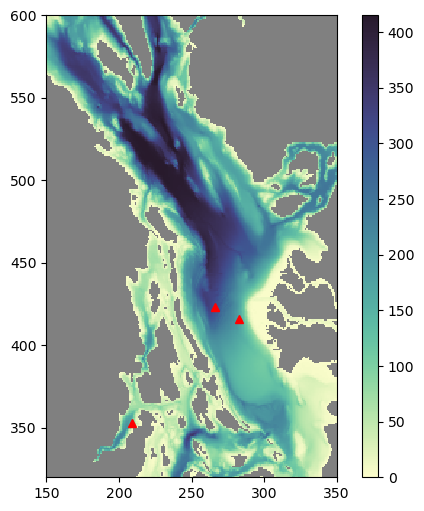

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
mycmap = cm.deep
mycmap.set_bad('grey')
im = ax.pcolormesh(bathy.variables['Bathymetry'][:], cmap=mycmap, vmin=0, vmax=415)
ax.plot(i_SI,j_SI,'r^')
ax.plot(i_SoG,j_SoG,'r^')
ax.plot(i_SoGE,j_SoGE,'r^')
ax.set_xlim([150, 350])
ax.set_ylim([320, 600])
viz_tools.set_aspect(ax);
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


In [12]:
df_chemTlr1

<xarray.Dataset>
Dimensions:           (time: 1096, depth: 40, gridY: 898, gridX: 398)
Coordinates:
  * time              (time) datetime64[ns] 2018-01-01T12:00:00 ... 2020-12-3...
  * depth             (depth) float32 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
  * gridY             (gridY) int64 0 1 2 3 4 5 6 ... 892 893 894 895 896 897
  * gridX             (gridX) int64 0 1 2 3 4 5 6 ... 392 393 394 395 396 397
Data variables:
    dissolved_oxygen  (time, depth, gridY, gridX) float32 dask.array<chunksize=(365, 40, 898, 398), meta=np.ndarray>
Attributes:
    name:         SalishSea_1d_chemo2_20180101_20181231
    description:  Hour-averaged dissolved O2 from SalishSea_oxy2 v202111 hind...
    history:      2024-04-21 12:14 -07:00: Generated by `reshapr extract /oce...
    Conventions:  CF-1.6

Text(0.5, 1.0, '')

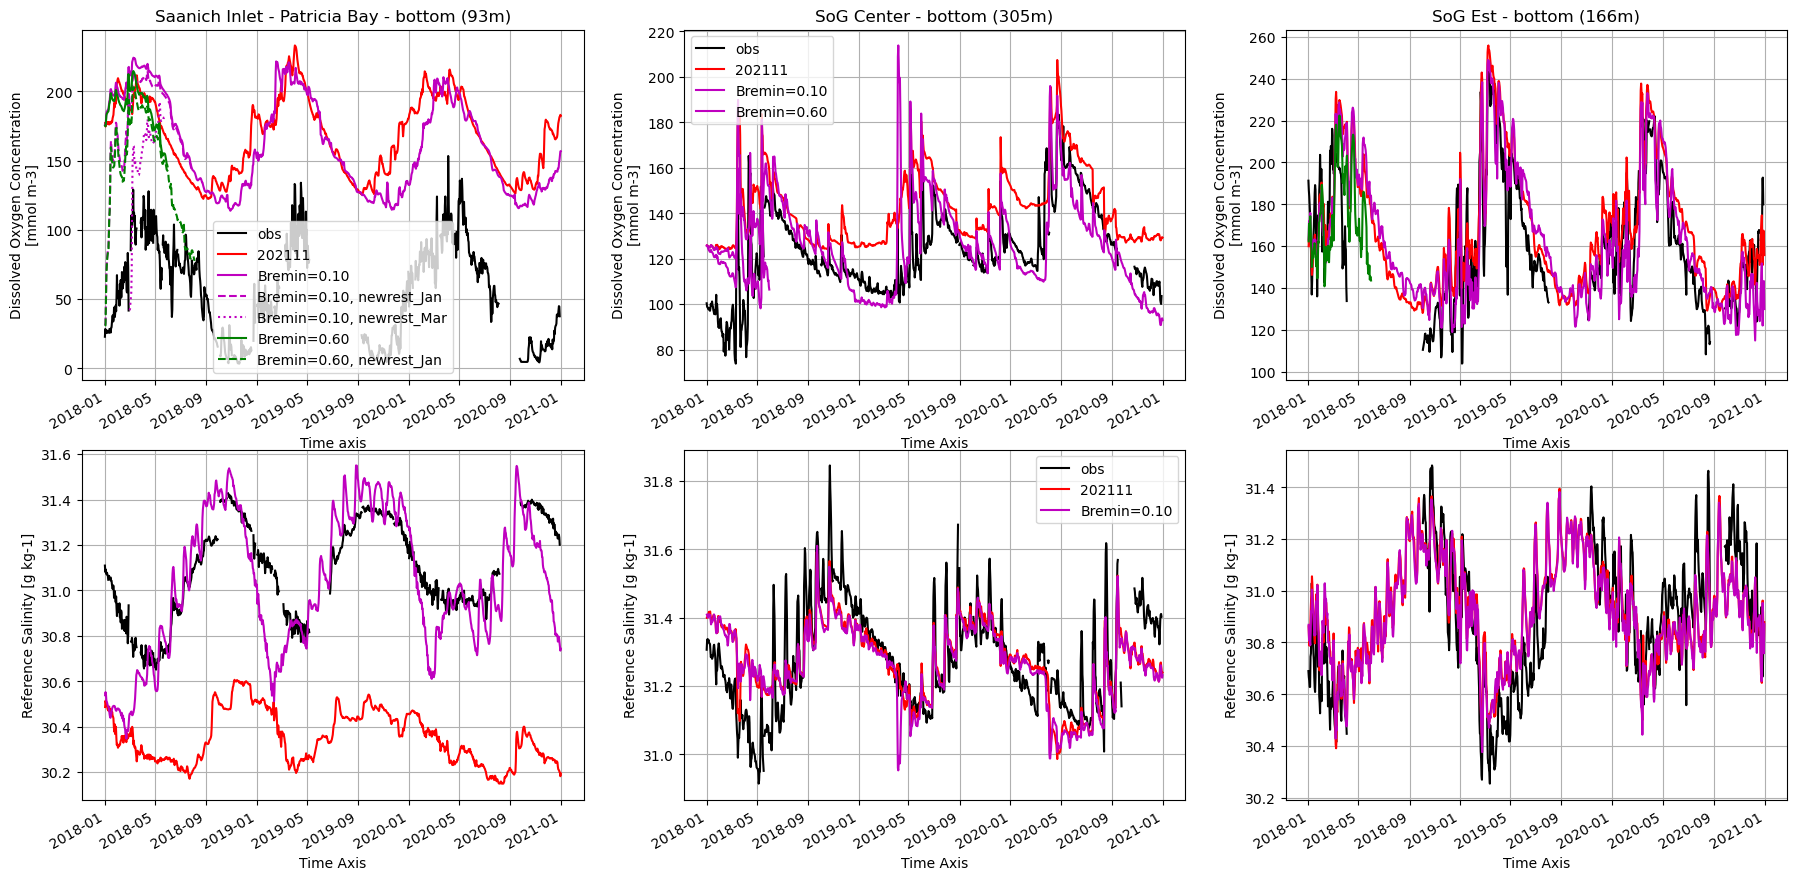

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(22, 10))
ax[0,0].plot(time[:1094],oxy_saan[:1094] * 44.661, 'k',label='obs')
df_chemTlr0['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time", color='r',label='202111')
df_chemTlr1['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time", color='m',label='Bremin=0.10')
df_chemTlr1a['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time_counter", color='m',linestyle='dashed',label='')
df_chemTlr1b['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time_counter", color='m',linestyle='dotted',label='')
df_chemTlr2['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time", color='g',label='Bremin=0.60')
df_chemTlr2a['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[0,0], x="time_counter", color='g',linestyle='dashed',label='')
ax[0,1].plot(time[:1094],oxy_sogC[:1094] * 44.661, 'k', label='obs')
df_chemTlr0['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[0,1], x="time", color='r',label='202111')
df_chemTlr1['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[0,1], x="time", color='m',label='Bremin=0.10')
df_chemTlr2['dissolved_oxygen'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[0,1], x="time", color='g',label='Bremin=0.60')
ax[0,2].plot(time[:1094],oxy_sogE[:1094] * 44.661, 'k', label='obs')
df_chemTlr0['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[0,2], x="time", color='r',label='202111')
df_chemTlr1['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[0,2], x="time", color='m',label='Bremin=0.10')
df_chemTlr2['dissolved_oxygen'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[0,2], x="time", color='g',label='Bremin=0.60')

ax[1,0].plot(time[:1094],sal_saan[:1094], 'k',label='obs')
df_gridTlr0['vosaline'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[1,0], x="time", color='r',label='202111')
df_gridTlr1['vosaline'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax[1,0], x="time", color='m',label='Bremin=0.10')
ax[1,1].plot(time[:1094],sal_sogC[:1094], 'k',label='obs')
df_gridTlr0['vosaline'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[1,1], x="time", color='r',label='202111')
df_gridTlr1['vosaline'][:, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG].where(tmask[0, mbathy[0, j_SoG, i_SoG]-1, j_SoG, i_SoG] == 1).plot(ax=ax[1,1], x="time", color='m',label='Bremin=0.10')
ax[1,2].plot(time[:1094],sal_sogE[:1094], 'k',label='obs')
df_gridTlr0['vosaline'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[1,2], x="time", color='r',label='202111')
df_gridTlr1['vosaline'][:, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE].where(tmask[0, mbathy[0, j_SoGE, i_SoGE]-1, j_SoGE, i_SoGE] == 1).plot(ax=ax[1,2], x="time", color='m',label='Bremin=0.10')

ax[0,0].grid()
ax[0,1].grid()
ax[0,2].grid()
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].grid()
ax[1,1].grid()
ax[1,2].grid()
#ax[1,1].legend()
ax[0,0].set_title('Saanich Inlet - Patricia Bay - bottom (93m)')
ax[0,1].set_title('SoG Center - bottom (305m)')
ax[0,2].set_title('SoG Est - bottom (166m)')
ax[1,0].set_title('')
ax[1,1].set_title('')
ax[1,2].set_title('')
#fig.suptitle('Model, PON sinking rate = 0.0001')
#fig.savefig('../figures_WQM-KC/DO_Obs-202111-2024XX-2024XXc-2024XXb-2024XXd_PatriciaBay.png',dpi = 300)

Text(0.5, 1.0, 'Saanich Inlet - Patricia Bay - bottom (93m)')

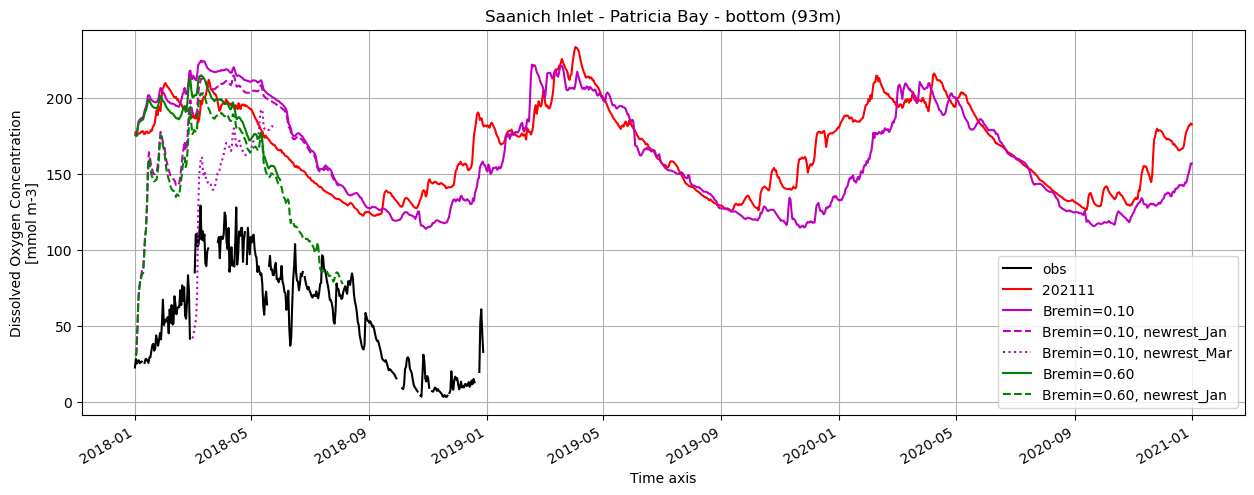

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(time[:365],oxy_saan[:365] * 44.661, 'k',label='obs')
df_chemTlr0['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax, x="time", color='r',label='202111')
df_chemTlr1['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax, x="time", color='m',label='Bremin=0.10')
df_chemTlr1a['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax, x="time_counter", color='m',linestyle='dashed',label='Bremin=0.10, newrest_Jan')
df_chemTlr1b['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax, x="time_counter", color='m',linestyle='dotted',label='Bremin=0.10, newrest_Mar')
df_chemTlr2['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax, x="time", color='g',label='Bremin=0.60')
df_chemTlr2a['dissolved_oxygen'][:, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI].where(tmask[0, mbathy[0, j_SI, i_SI]-1, j_SI, i_SI] == 1).plot(ax=ax, x="time_counter", color='g',linestyle='dashed',label='Bremin=0.60, newrest_Jan')

ax.grid()
ax.legend()
ax.set_title('Saanich Inlet - Patricia Bay - bottom (93m)')

